# Test Treefrog Module

## Prepare session

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from IPython.core.display import display, HTML
import fcgadgets.utilities.utilities_general as gu
import treefrog.treefrog_functions as treefrog

In [2]:
%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:80% !important; } .output {align-items: center; }</style>"))

In [3]:
params_graphic=gu.Import_GraphicsParameters('ipynb')
plt.rcParams.update(params_graphic)

Import constants used in hydrometeorology.

In [4]:
con=treefrog.HydroMetCon()

## Evapotranspiration

Define variables.

In [5]:
vD={}
vD['Tme']=np.array([1,7])
vD['vpd']=np.arange(1,19,1); fl=np.ones(vD['vpd'].shape)
vD['rswd']=24*fl
vD['rswn']=(1-con['Albedo']['Forest Coniferous'])*vD['rswd'] 
vD['ta']=18*fl
vR={}
vR['Tme']=np.array([1,7])
vR['rswd']=np.arange(1,29,1); fl=np.ones(vR['rswd'].shape)
vR['vpd']=12*fl
vR['rswn']=(1-con['Albedo']['Forest Coniferous'])*vR['rswd']
vR['ta']=18*fl

Look at the sensitivity of potential evapotranspiration to vapour pressure deficit and radiation.

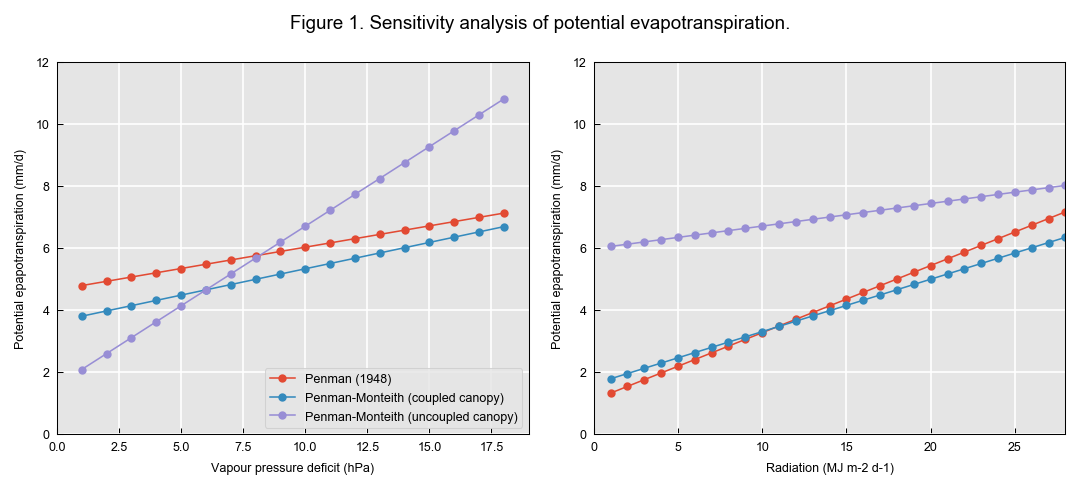

In [7]:
fig,ax=plt.subplots(1,2,figsize=gu.cm2inch(18,8))
ETp_Penman=treefrog.GetETp(vD,'Penman','d')
ax[0].plot(vD['vpd'],ETp_Penman,'-o',label='Penman (1948)')
vD['Ga']=0.01; vD['Gs']=0.012; ETp=treefrog.GetETp(vD,'Penman-Monteith','d')
ax[0].plot(vD['vpd'],ETp,'-o',label='Penman-Monteith (coupled canopy)')
vD['Ga']=0.07; vD['Gs']=0.012; ETp=treefrog.GetETp(vD,'Penman-Monteith','d')
ax[0].plot(vD['vpd'],ETp,'-o',label='Penman-Monteith (uncoupled canopy)')
ax[0].set(ylim=[0,12],xlim=[0,19],ylabel='Potential epapotranspiration (mm/d)',xlabel='Vapour pressure deficit (hPa)')
ax[0].legend(loc='lower right')
ETp_Penman=treefrog.GetETp(vR,'Penman','d')
ax[1].plot(vR['rswd'],ETp_Penman,'-o',label='Penman (1948)')
vR['Ga']=0.01; vR['Gs']=0.012; ETp=treefrog.GetETp(vR,'Penman-Monteith','d')
ax[1].plot(vR['rswd'],ETp,'-o',label='Penman-Monteith (coupled canopy)')
vR['Ga']=0.07; vR['Gs']=0.012; ETp=treefrog.GetETp(vR,'Penman-Monteith','d')
ax[1].plot(vR['rswd'],ETp,'-o',label='Penman-Monteith (uncoupled canopy)')
ax[1].set(ylim=[0,12],xlim=[0,28],ylabel='Potential epapotranspiration (mm/d)',xlabel='Radiation (MJ m-2 d-1)')
fig.suptitle('Figure 1. Sensitivity analysis of potential evapotranspiration.');

## Water balance
Import monthly climate data for the Cowichan River valley, B.C. and convert to a dictionary. The data come with downwelling shortwave radiation, but the water balance model requires net shortwave radiation. Use the albedo values from the constants dictionary to calculate net shortwave radiation.

In [12]:
clm=pd.read_excel(r'C:\Users\rhember\Documents\Code_Python\treefrog\climate_data_for_treefrog_test.xlsx')

In [13]:
vi={}
for nam in clm.columns:
    vi[nam]=np.reshape(clm[nam].values,(-1,1))

In [14]:
vi['rswn']=(1-con['Albedo']['Forest Coniferous'])*vi['rswd'] 
vi['LAI']=5.5
vi['Gs']=0.010
vi['Ga']=0.058

Set parameters and run the water balance model. Assume maximum soil water holding capacity of 200 mm. Use the Penman-Monteith equation to estimate evapotranspiration during periods of unlimited water supply. Assume a forest canopty that is moderately-well coupled to the atmosphere.

In [15]:
par={}
par['Method']='Combined'
par['Ws_max']=200.0 # mm
par['Tmin']=-3.0
par['Tmax']=3.0
par['Ei_FracMax']=0.15
par['Ei_ALMax']=5.0
par['ETp Method']='Penman-Monteith'
par['Daily_Interval']=5
par['Include Rainfall Fraction']='Yes'

In [16]:
vo=treefrog.Tadpole(par,vi)

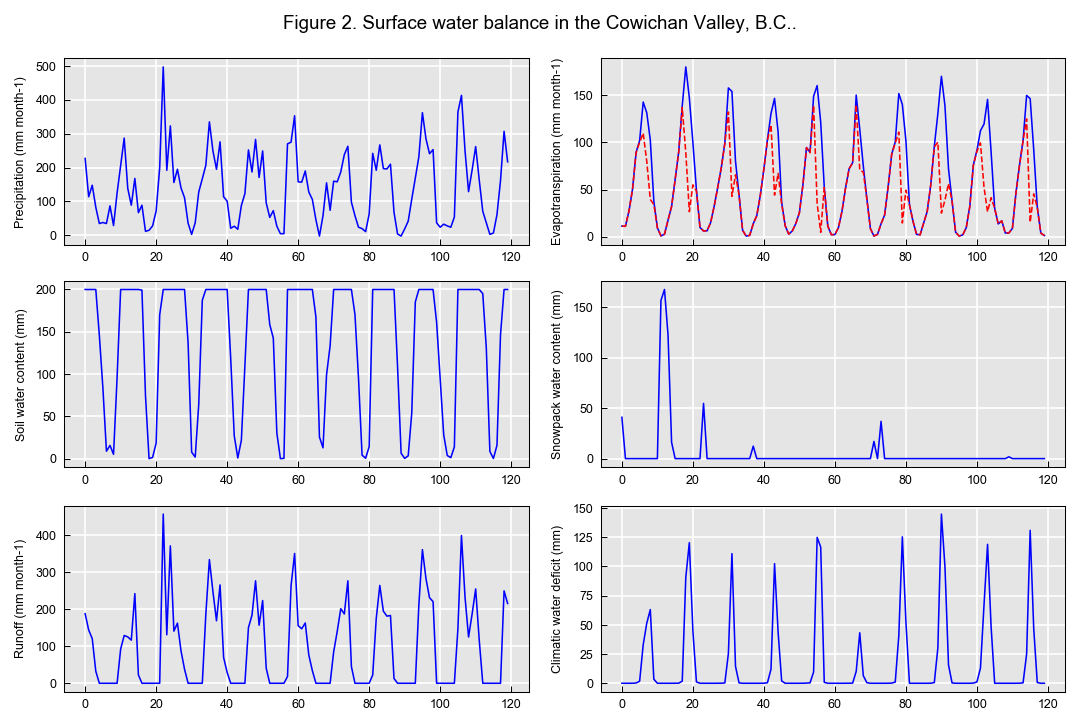

In [17]:
it=np.where( (vi['Year']>=2008) & (vi['Year']<=2017) )[0]
fig,ax=plt.subplots(3,2,figsize=gu.cm2inch(18,12))
ax[0,0].plot(vi['prcp'][it,0],'b-')
ax[0,1].plot(vo['ETp'][it,0],'b-')
ax[0,1].plot(vo['ETa'][it,0],'r--')
ax[1,0].plot(vo['Ws'][it,0],'b-')
ax[1,1].plot(vo['Wsp'][it,0],'b-')
ax[2,0].plot(vo['R'][it,0],'b-')
ax[2,1].plot(vo['ETp'][it,0]-vo['ETa'][it,0],'b-')
ax[0,0].set(ylabel='Precipitation (mm month-1)')
ax[0,1].set(ylabel='Evapotranspiration (mm month-1)')
ax[1,0].set(ylabel='Soil water content (mm)')
ax[1,1].set(ylabel='Snowpack water content (mm)')
ax[2,0].set(ylabel='Runoff (mm month-1)')
ax[2,1].set(ylabel='Climatic water deficit (mm)')
fig.suptitle('Figure 2. Surface water balance in the Cowichan Valley, B.C..');